<a href="https://colab.research.google.com/github/acevedosharp/ensemble-testing-chamber/blob/master/notebooks/ensemble_classifier_combination_tester.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Measuring the effectiveness of ensembles

- assemble all possible combination of ensembles $k \in \{1,2,3,4,5\}$
- 10-fold cross validation
- the single best learner (according to some cross-validation) for each dataset
- for each $k \in \{2,3,4,5\}$, how many ensembles do improve over the single best learner by at least $0.005$ (absolute and relative counts of improvement)
- for each base learner understand in how many improving ensembles it is contained (absolute and relative numbers)

## Experimental setup

In [1]:
# ignore sklearn warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import itertools
import random
import openml
import numpy as np
import pandas as pd
import sklearn
from datetime import datetime
import matplotlib.pyplot as plt
from functools import reduce

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer

# classifiers
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from datetime import datetime

In [2]:
allDatasets = [
  (1485 , 'madelon'),
  # (42734, 'okcupid-stem'), requires too much preprocessing
  (1169 , 'airlines'),
  # (42733, 'Click_prediction_small'), after creating dummy columns it becomes way too large to fit on machines with less than 32gb of memory.
  (41150, 'MiniBooNE'),
  (54   , 'vehicle'), 
  (40981, 'Australian'),
  (40975, 'car'),
  (40670, 'dna'),
  (31   , 'credit-g'),
  (41169, 'helena'),
  (41168, 'jannis'),
  (41167, 'di  nis'),
  (41166, 'volkert'),
  (41165, 'robert'),
  (41164, 'fabert'),
  (41163, 'dilbert'),
  (41162, 'kick'),
  (41161, 'riccardo'),
  (41159, 'guillermo'),
]

indicesToRun = [9] # list(range(len(allDatasets)))
rawDatasets = { allDatasets[i][1]: openml.datasets.get_dataset(allDatasets[i][0]) for i in indicesToRun } # download the datasets that will actually be used for the experiment

datasets = { }

for datasetName, rawDataset in rawDatasets.items():
  X, Y, categorical_indicator, attribute_names = rawDatasets[datasetName].get_data(
    dataset_format="dataframe", target=rawDatasets[datasetName].default_target_attribute
  )
  if X.shape[0] > 25000: 
    arr = np.arange(0, X.shape[0])
    random.shuffle(arr)
    X = X.iloc[arr[:25000]]
    Y = Y.iloc[arr[:25000]]
  
  X = pd.get_dummies(X).to_numpy()
  Y = Y.to_numpy()
  
  datasets[datasetName] = (
      X,
      LabelEncoder().fit_transform(Y), # make sure all clases are integers
      categorical_indicator
  )


In [3]:
datasets.keys()

dict_keys(['jannis'])

In [4]:
datasets['jannis'][0].shape

(25000, 54)

In [12]:
classifiers = {
    "Linear SVC": LinearSVC(),
    "Decision Tree": DecisionTreeClassifier(),
    "Extra Tree": ExtraTreeClassifier(),
    "Logistic": LogisticRegression(),
    "Passive Aggressive": PassiveAggressiveClassifier(),
    "Perceptron": Perceptron(),
    "Ridge": RidgeClassifier(),
    "SGD": SGDClassifier(),
    "Multi-layer Perceptron": MLPClassifier(),
    "Linear Discriminant": LinearDiscriminantAnalysis(),
    "Quadratic Discriminant": QuadraticDiscriminantAnalysis(),
    "BernoulliNB": BernoulliNB(),
    # don't forget to comment it when dataset contains negative values
    #"MultinomialNB": MultinomialNB(),
    "Nearest Neighbors": KNeighborsClassifier(),
    "Extra Trees": ExtraTreesClassifier(),
    "Random Forest (10 estimators)": RandomForestClassifier(n_estimators=10),
    "Gradient Boosting": GradientBoostingClassifier()
}

### Execute experiments

In [13]:
# 10-fold cross validation, take only 25k instances for training in dataset if larger
FOLDS = 10

results = []
singleClassifiersRuntimeAcrossDifferentFolds = [{classifier: (datetime.now() - datetime.now()) for classifier in classifiers.keys()} for i in range(FOLDS)]

kf = KFold(n_splits=FOLDS)
for dataset in datasets.keys():
  X, Y = datasets[dataset][0], datasets[dataset][1]
  #X = StandardScaler().fit_transform(X)
  fold_index = 0
  for train_index, test_index in kf.split(X):
    fold_start_time = datetime.now()
    print(">>> Fold", fold_index)
    X_train, X_test = X[train_index], X[test_index] # np.take
    Y_train, Y_test = Y[train_index], Y[test_index] # np.take

    # Train every classifier with the new data
    trainStartTime = datetime.now()
    for classifier_name, classifier in classifiers.items():
      print(f"Training {classifier_name}", end='')
      classifierStartTime = datetime.now()
      classifier.fit(X_train, Y_train)
      delta = datetime.now() - classifierStartTime
      print(f'({datetime.now() - classifierStartTime})')
      singleClassifiersRuntimeAcrossDifferentFolds[fold_index][classifier_name] = delta
    print(f'Training all classifiers on data took {datetime.now() - trainStartTime}')

    # Assemble ensembles of size k in {1,2,3,4,5}
    for k in range(1,6):
      print("\t>>> k:", k)
      kStartTime = datetime.now()
      for combination in list(itertools.combinations(classifiers.keys(), k)):
        singleEnsembleStartTime = datetime.now()
        ensemble = []
        ensemble_description = ""

        # group classifiers (already exist fitted in dict)
        for idx in range(k):
          ensemble.append(classifiers[combination[idx]])
          ensemble_description += combination[idx]
          ensemble_description += "-"
        ensemble_description = ensemble_description[:-1]

        # save predictions
        predictions = np.zeros((len(X_test), k)) # (# test instances, ensemble size)
        for idx, classifier in enumerate(ensemble):
          predictions[:,idx] = classifier.predict(X_test)
        
        # do hard voting
        hard_voting_predictions = np.zeros((len(X_test), 1)) # (# test instances, 1)
        for idx in range(predictions.shape[0]):
          values, counts = np.unique(predictions[idx], return_counts=True)
          hard_voting_predictions[idx] = values[np.argmax(counts)]
        
        # compare voting predictions against Y_test
        total_instance_number = len(X_test)
        errors = 0
        for idx in range(hard_voting_predictions.shape[0]):
          if (hard_voting_predictions[idx][0] != Y_test[idx]):
            errors += 1
        score = errors/total_instance_number

        # save result (ensemble description, ensemble size, fold index, dataset, score, timedelta)
        results.append((ensemble_description, k, fold_index, dataset, score, datetime.now() - singleEnsembleStartTime))
      print(f"k took {datetime.now() - kStartTime}")

    fold_index += 1
    print(">>> fold took:", datetime.now() - fold_start_time)
        

>>> Fold 0
Training Linear SVC(0:00:24.170993)
Training Decision Tree(0:00:01.918041)
Training Extra Tree(0:00:00.053987)
Training Logistic(0:00:01.233976)
Training Passive Aggressive(0:00:00.374026)
Training Perceptron(0:00:00.267001)
Training Ridge(0:00:00.028967)
Training SGD(0:00:04.922002)
Training Multi-layer Perceptron(0:00:05.597999)
Training Linear Discriminant(0:00:00.160001)
Training Quadratic Discriminant(0:00:00.055002)
Training BernoulliNB(0:00:00.021000)
Training Nearest Neighbors(0:00:00.002999)
Training Extra Trees(0:00:04.194038)
Training Random Forest (10 estimators)(0:00:01.427007)
Training Gradient Boosting(0:02:31.877010)
Training all classifiers on data took 0:03:16.306045
	>>> k: 1
k took 0:00:02.368987
	>>> k: 2
k took 0:00:32.627997
	>>> k: 3
k took 0:03:30.007000
	>>> k: 4
k took 0:13:09.473898
	>>> k: 5
k took 0:39:39.209207
>>> fold took: 1:00:10.004152
>>> Fold 1
Training Linear SVC(0:00:24.579053)
Training Decision Tree(0:00:01.798023)
Training Extra Tree

## Analysing results

### Utility functions

In [14]:
def saveResultsAsCsv(filename, headers, rows):
  if len(headers) == len(rows[0]):
    with open(filename,'w') as file:
      file.write(','.join(headers))
      file.write('\n')
      for row in rows:
        file.write(','.join(list(map(lambda rc: str(rc), row))))
        file.write('\n')
  else:
    raise Exception('length of headers does not match length of single rows.')

def filterResultsByDataset(datasetName, results):
  return list(filter(lambda res: str(res[2]) == datasetName, results))

def loadResultsFromCsv(filename):
  loadedResults = []
  with open(filename) as file:
    loadedResults = list(map(lambda entry: entry.split(','), [x.strip() for x in file.readlines()]))
  file.close()
  print('Headers are:', loadedResults[0])
  del loadedResults[0]
  return loadedResults


### Aggregate data

In [15]:
results = list(map(lambda entry: (entry[0], entry[1], entry[2], entry[3], entry[4], entry[5].total_seconds()*1000), results))

In [16]:
resultsDf = pd.DataFrame(results, columns=['ensembleDescription', 'ensembleSize', 'foldIndex', 'dataset', 'errorRate', 'timeTaken'])

In [17]:
finalResults = []

# (ensemble description, ensemble size, fold index, dataset, score, timedelta)
for ensemble_description, matchingResults in resultsDf.groupby(['ensembleDescription']):
  matchingIterable = matchingResults.values
  meanError = 0
  meanTimeTaken = 0
  for row in matchingIterable:
    meanError += float(row[4])
    meanTimeTaken += float(row[5])
  meanError /= 10
  meanTimeTaken /= 10
  # (ensemble_description, ensemble_size, dataset, mean_error, time_taken)
  finalResults.append((
      ensemble_description, # matchingIterable[0][0]
      matchingIterable[0][1], 
      matchingIterable[0][3], 
      meanError, 
      meanTimeTaken
  ))

In [ ]:
finalResults = loadResultsFromCsv('finalResults.csv')

### Save results

In [18]:
saveResultsAsCsv('finalResultsJannis.csv', ['ensembleDescription', 'k', 'dataset', 'errorRate', 'timeTaken'], finalResults)

### Load results

In [19]:
finalResults = loadResultsFromCsv('finalResultsJannis.csv')
resultsDf = pd.read_csv('finalResultsJannis.csv')

Headers are: ['ensembleDescription', 'k', 'dataset', 'errorRate', 'timeTaken']


### Metrics

#### Error rates for different sizes of k

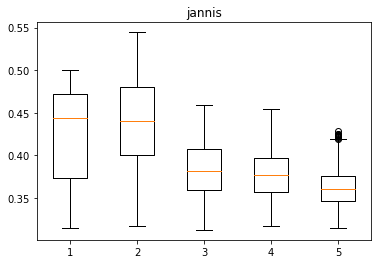

In [20]:
for dataset, matchingResults in resultsDf.groupby(['dataset']): 
  boxplots = []
  for k, matchingKs in matchingResults.groupby(['k']):
    boxplots.append(matchingKs['errorRate'].values)
  fig, ax = plt.subplots()
  ax.boxplot(boxplots)
  ax.set_title(dataset)
  plt.show()  

#### Best single learners for every dataset

In [21]:
bestSingleLearners = {} # dataset: (ensembleDescription, errorRate)

for dataset, matchingResults in resultsDf.groupby(['dataset']): 
  matchingK1s = matchingResults.loc[resultsDf['k'] == 1]
  minIndex = matchingK1s['errorRate'].idxmin()
  minRow = resultsDf.iloc[minIndex]
  bestSingleLearners[dataset] = (minRow['ensembleDescription'], minRow['errorRate'])

bestSingleLearners

{'jannis': ('Gradient Boosting', 0.31464)}

#### For every $k \in \{2,3,4,5\}$, how many ensembles do improve over the single best learner by at least $0.01 (1\%)$ (absolute and relative counts of improvement)

In [ ]:
resultsDf[resultsDf['k'] == 1]

In [25]:
improvementMargin = 0.01

improvementEnsembles = {dataset: [] for dataset in bestSingleLearners.keys()} # dataset: (ensembleDescription, errorRate, k)

for dataset, matchingResults in resultsDf.groupby(['dataset']): 
  for k, matchingKs in matchingResults.groupby(['k']):
    if k != 1: # ...
      for i, row in matchingKs.iterrows():
        if (row['errorRate'] + improvementMargin) < bestSingleLearners[dataset][1]:
          improvementEnsembles[dataset].append((row['ensembleDescription'], row['errorRate'], k))

In [26]:
for dataset in improvementEnsembles.keys():
  print(f"\n{dataset}'s best single learner had an error rate of: {bestSingleLearners[dataset][1]}")
  nImproved = len(improvementEnsembles[dataset])
  print(f"\t{nImproved} ({round(nImproved/resultsDf[(resultsDf['dataset'] == dataset) & (resultsDf['k'] != 1)]['dataset'].count()*100, 2)}%) ensembles improved by at least {improvementMargin} ({improvementMargin*100}%)")
  for k in range(2, 6):
    matchingImprovementEnsemblesWithK = list(filter(lambda entry: entry[2] == k, improvementEnsembles[dataset]))
    print(f"\t\t{len(matchingImprovementEnsemblesWithK)} with k={k} - mean error rate: {np.mean(list(map(lambda tup: tup[1], matchingImprovementEnsemblesWithK)))}")


jannis's best single learner had an error rate of: 0.31464
	0 (0.0%) ensembles improved by at least 0.01 (1.0%)
		0 with k=2 - mean error rate: nan
		0 with k=3 - mean error rate: nan
		0 with k=4 - mean error rate: nan
		0 with k=5 - mean error rate: nan


C:\Users\aceve\miniconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


#### For each base learner understand in how many improving ensembles it is contained (absolute and relative numbers)

In [29]:
for dataset in datasets.keys():
  print(f'Dataset: {dataset}')
  improvers = [] # classifier, timesAppearedInImprovements, timesAppearedInImprovementsRelative
  for classifier in classifiers.keys():
    timesAppearedInImprovements = 0
    for row in improvementEnsembles[dataset]:
      if classifier in row[0]:
        timesAppearedInImprovements += 1
    if len(improvementEnsembles[dataset]) != 0:
      improvers.append((classifier, timesAppearedInImprovements, timesAppearedInImprovements/len(improvementEnsembles[dataset])))
    else:
      improvers.append((classifier, 0, 0))

  for entry in sorted(improvers, key=lambda tup: tup[1], reverse=True):
    print(f"\t{entry[0]}: {entry[1]} ({entry[2]*100}%)")
  print()

Dataset: jannis
	Linear SVC: 0 (0%)
	Decision Tree: 0 (0%)
	Extra Tree: 0 (0%)
	Logistic: 0 (0%)
	Passive Aggressive: 0 (0%)
	Perceptron: 0 (0%)
	Ridge: 0 (0%)
	SGD: 0 (0%)
	Multi-layer Perceptron: 0 (0%)
	Linear Discriminant: 0 (0%)
	Quadratic Discriminant: 0 (0%)
	BernoulliNB: 0 (0%)
	Nearest Neighbors: 0 (0%)
	Extra Trees: 0 (0%)
	Random Forest (10 estimators): 0 (0%)
	Gradient Boosting: 0 (0%)

